In [1]:
# Para que funcione, todos nuestros scripts debemos exportar las siguientes variables de entorno
%env AWS_ACCESS_KEY_ID=minio   
%env AWS_SECRET_ACCESS_KEY=minio123 
%env MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
%env AWS_ENDPOINT_URL_S3=http://localhost:9000

env: AWS_ACCESS_KEY_ID=minio
env: AWS_SECRET_ACCESS_KEY=minio123
env: MLFLOW_S3_ENDPOINT_URL=http://localhost:9000
env: AWS_ENDPOINT_URL_S3=http://localhost:9000


In [2]:
!echo $AWS_ACCESS_KEY_ID
!echo $AWS_SECRET_ACCESS_KEY
!echo $MLFLOW_S3_ENDPOINT_URL

$AWS_ACCESS_KEY_ID
$AWS_SECRET_ACCESS_KEY
$MLFLOW_S3_ENDPOINT_URL


In [3]:
best_runs = []

In [4]:
# ========================== BLOQUE 1 ==========================
# 📌 CARGA DE DATOS Y BÚSQUEDA DE HIPERPARÁMETROS CON OPTUNA USANDO AUC
import os
import awswrangler as wr
import boto3
from botocore.exceptions import ClientError
import pandas as pd
import optuna
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# 🚀 Cargar los datos desde AWS S3
X_train = wr.s3.read_csv("s3://data/final/train/X_train_scaled.csv")
y_train = wr.s3.read_csv("s3://data/final/train/y_train.csv")
X_val = wr.s3.read_csv("s3://data/final/val/X_val_scaled.csv")
y_val = wr.s3.read_csv("s3://data/final/val/y_val.csv")
X_test = wr.s3.read_csv("s3://data/final/test/X_test_scaled.csv")
y_test = wr.s3.read_csv("s3://data/final/test/y_test.csv")

experiment_name = "Cross Validation AUC Threshold Optimization"
experiment_path = experiment_name.lower().replace(' ', '_')

# 🔹 Configurar MLflow
mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment(experiment_name)

# 🔹 Combinar conjuntos de entrenamiento y validación para CV
X_combined = pd.concat([X_train, X_val])
y_combined = pd.concat([y_train, y_val])

# 📌 Función objetivo para Optuna con validación cruzada usando AUC
def objective(trial):
    global best_runs
    
    classifier_name = trial.suggest_categorical('classifier', 
        ['RandomForest', 'XGBoost', 'SVC', 'LogisticRegression', 'KNN'])

    n_splits = 5  # Número de folds para validación cruzada
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # 🔹 Definir hiperparámetros según el modelo
    if classifier_name == 'RandomForest':
        print(f"Optimizando modelo: {classifier_name}")
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('n_estimators', 10, 100),
            max_depth=trial.suggest_int('max_depth', 2, 32)
        )
    elif classifier_name == 'XGBoost':
        print(f"Optimizando modelo: {classifier_name}")
        model = XGBClassifier(
            eta=trial.suggest_float('eta', 0.01, 0.5),  # Tasa de aprendizaje
            max_depth=trial.suggest_int('max_depth', 2, 20),  # Profundidad máxima del árbol
            n_estimators=trial.suggest_int('n_estimators', 50, 500),  # Número de árboles
            subsample=trial.suggest_float('subsample', 0.5, 1.0),  # Fracción de muestras para cada árbol
            colsample_bytree=trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Fracción de características usadas
            reg_lambda=trial.suggest_float('reg_lambda', 0.1, 10.0),  # Regularización L2
            reg_alpha=trial.suggest_float('reg_alpha', 0.0, 10.0),  # Regularización L1
            min_child_weight=trial.suggest_int('min_child_weight', 1, 10),  # Control de sobreajuste
            gamma=trial.suggest_float('gamma', 0.0, 5.0),  # Poda de ramas en árboles
            objective="binary:logistic",  # Tarea de clasificación binaria
            eval_metric="logloss",  # Métrica para evaluar
            use_label_encoder=False  # Evita warnings en XGBoost >=1.3
        )
    elif classifier_name == 'SVC':
        kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])

        # Definir gamma correctamente sin cambiar la configuración de log
        if kernel == 'linear':
            gamma = 'scale'  # Valor por defecto cuando no se usa gamma
        else:  # Solo optimizar gamma si es 'rbf' o 'poly'
            gamma = trial.suggest_float('gamma_svc', 1e-4, 1.0, log=True)

        model = SVC(
            C=trial.suggest_float('C_svc', 0.1, 10.0, log=True),  # Usar nombres únicos
            kernel=kernel,
            gamma=gamma,  # Se usa gamma solo cuando es necesario
            probability=True
        )
    elif classifier_name == 'LogisticRegression':
        print(f"Optimizando modelo: {classifier_name}")
        model = LogisticRegression(
            C=trial.suggest_float('C', 0.1, 10.0, log=True),
            penalty=trial.suggest_categorical('penalty', ['l1', 'l2']),
            solver='liblinear'
        )
    elif classifier_name == 'KNN':
        print(f"Optimizando modelo: {classifier_name}")
        model = KNeighborsClassifier(
            n_neighbors=trial.suggest_int('n_neighbors', 3, 15),
            weights=trial.suggest_categorical('weights', ['uniform', 'distance']),
            p=trial.suggest_int('p', 1, 2),
            metric=trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski']),
            leaf_size=trial.suggest_int('leaf_size', 10, 50)
        )

    # 🔹 Validación cruzada
    cv_auc_scores = []
    with mlflow.start_run(run_name=f"{classifier_name}_cv_run"):
        mlflow.log_param("classifier", classifier_name)
        mlflow.log_params(trial.params)

        for train_idx, val_idx in kf.split(X_combined):
            X_fold_train, y_fold_train = X_combined.iloc[train_idx], y_combined.iloc[train_idx]
            X_fold_val, y_fold_val = X_combined.iloc[val_idx], y_combined.iloc[val_idx]

            model.fit(X_fold_train, y_fold_train.values.ravel())
            y_probs = model.predict_proba(X_fold_val)[:, 1]  # Obtener probabilidades de clase positiva
            cv_auc_scores.append(roc_auc_score(y_fold_val, y_probs))
        
        mean_cv_auc = np.mean(cv_auc_scores)
        mlflow.log_metric("mean_cv_auc", mean_cv_auc)

        # Entrenar el modelo final con el conjunto completo de datos
        final_model = model.fit(X_combined, y_combined.values.ravel())
        
        # Verificar si el modelo ya está en la lista antes de agregarlo
        if not any(clf_name == "LogisticRegression" and params == trial.params for _, _, clf_name, params in best_runs):
            best_runs.append((mean_cv_auc, final_model, classifier_name, trial.params))

        # Mantener solo los 5 mejores
        best_runs = sorted(best_runs, key=lambda x: x[0], reverse=True)[:5]

        print("\nTop 5 modelos seleccionados:")
        for auc, _, clf, _ in best_runs:
            print(f"{clf}: AUC = {auc:.4f}")
        
        return mean_cv_auc

# 🚀 Ejecutar la optimización con Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Log solo los 5 mejores modelos a MLflow
print("\nTop 5 models:")
top_run_ids = []  # Guardar IDs de las siguientes ejecuciones
for i, (score, model, clf_name, params) in enumerate(best_runs, 1):
    with mlflow.start_run(run_name=f"top_model_{i}_{clf_name}"):
        mlflow.log_params(params)
        mlflow.log_metric("mean_cv_auc", score)
        mlflow.log_param("classifier_name", clf_name)
        mlflow.sklearn.log_model(model, "model")
        run_id = mlflow.active_run().info.run_id
        top_run_ids.append(run_id)
        print(f"{i}. {clf_name} - AUC: {score:.4f}")
        print(f"   Run ID: {run_id}")

# Guardar IDs de las ejecuciones en S3 para el siguiente notebook
run_ids_df = pd.DataFrame({
    'run_id': top_run_ids,
    'auc_score': [score for score, _, _, _ in best_runs],
    'classifier': [clf_name for _, _, clf_name, _ in best_runs]
})

# Create S3 client directly
s3_client = boto3.client(
    's3',
    endpoint_url=os.environ.get('AWS_ENDPOINT_URL_S3', 'http://localhost:9000'),
    aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID', 'minio'),
    aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY', 'minio123'),
    region_name='us-east-1'
)

bucket_name = 'models'
try:
    # Try to access the bucket
    s3_client.head_bucket(Bucket=bucket_name)
    print(f"Bucket {bucket_name} already exists")
except ClientError as e:
    error_code = e.response.get('Error', {}).get('Code')
    if error_code == '404' or error_code == 'NoSuchBucket':
        # Bucket does not exist, create it
        print(f"Creating bucket {bucket_name}")
        s3_client.create_bucket(Bucket=bucket_name)
    else:
        # Something else went wrong
        print(f"Error checking bucket: {e}")

# Now save the DataFrame to S3 using awswrangler
wr.s3.to_csv(run_ids_df, f's3://models/{experiment_path}/top_5_run_ids.csv', index=False)

# wr.s3.to_csv(run_ids_df, 's3://models/{experiment_path}/top_5_run_ids.csv', index=False)

c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-03-08 20:20:31,139] A new study created in memory with name: no-name-5448915f-dc27-4cc6-9aac-a7aa944b9963
2025/03/08 20:20:32 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_cv_run at: http://localhost:5000/#/experiments/23/runs/ceb5e8b5dbe742de82c16e337d2ce155.
2025/03/08 20:20:32 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:32,985] Trial 0 finished with value: 0.9127971281949459 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'gamma_svc': 0.7018646467441408, 'C_svc': 1.2042067524460969}. Best is trial 0 with value: 0.9127971281949459.



Top 5 modelos seleccionados:
SVC: AUC = 0.9128


2025/03/08 20:20:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_cv_run at: http://localhost:5000/#/experiments/23/runs/cc4dfa767e5c4522b603d3383525016c.
2025/03/08 20:20:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:33,485] Trial 1 finished with value: 0.8693974030044054 and parameters: {'classifier': 'SVC', 'kernel': 'rbf', 'gamma_svc': 0.13094872377157618, 'C_svc': 0.10099477466099832}. Best is trial 0 with value: 0.9127971281949459.



Top 5 modelos seleccionados:
SVC: AUC = 0.9128
SVC: AUC = 0.8694
Optimizando modelo: RandomForest


2025/03/08 20:20:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/9bcda9f61cee4edeadcf691735dbb3e3.
2025/03/08 20:20:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:34,562] Trial 2 finished with value: 0.8939874563981345 and parameters: {'classifier': 'RandomForest', 'n_estimators': 93, 'max_depth': 30}. Best is trial 0 with value: 0.9127971281949459.



Top 5 modelos seleccionados:
SVC: AUC = 0.9128
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
Optimizando modelo: KNN

Top 5 modelos seleccionados:
SVC: AUC = 0.9128
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
KNN: AUC = 0.7047


2025/03/08 20:20:34 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_cv_run at: http://localhost:5000/#/experiments/23/runs/8712e38d36484e52ba11cee9f3d1b306.
2025/03/08 20:20:34 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:34,738] Trial 3 finished with value: 0.7047068198090203 and parameters: {'classifier': 'KNN', 'n_neighbors': 4, 'weights': 'distance', 'p': 2, 'metric': 'euclidean', 'leaf_size': 16}. Best is trial 0 with value: 0.9127971281949459.


Optimizando modelo: RandomForest


2025/03/08 20:20:35 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/dd87796301204ff0aec1ae8c9124ec78.
2025/03/08 20:20:35 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:35,398] Trial 4 finished with value: 0.9317436806486334 and parameters: {'classifier': 'RandomForest', 'n_estimators': 62, 'max_depth': 4}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
KNN: AUC = 0.7047
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
Optimizando modelo: LogisticRegression


2025/03/08 20:20:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/46f1261cbbb24109ac90a62d1d9b1d16.
2025/03/08 20:20:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:36,576] Trial 6 finished with value: 0.8597470934180137 and parameters: {'classifier': 'LogisticRegression', 'C': 0.10507541662061813, 'penalty': 'l1'}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
Optimizando modelo: KNN


2025/03/08 20:20:36 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_cv_run at: http://localhost:5000/#/experiments/23/runs/4a8ce156c2dd438b9c48973745011b9f.
2025/03/08 20:20:36 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:36,828] Trial 7 finished with value: 0.7260026052899068 and parameters: {'classifier': 'KNN', 'n_neighbors': 5, 'weights': 'distance', 'p': 1, 'metric': 'manhattan', 'leaf_size': 37}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
Optimizando modelo: KNN


2025/03/08 20:20:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_cv_run at: http://localhost:5000/#/experiments/23/runs/a75c4efae01d46968a7c0740b25e98c6.
2025/03/08 20:20:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:37,051] Trial 8 finished with value: 0.7112481299712667 and parameters: {'classifier': 'KNN', 'n_neighbors': 4, 'weights': 'uniform', 'p': 2, 'metric': 'manhattan', 'leaf_size': 13}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694


2025/03/08 20:20:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_cv_run at: http://localhost:5000/#/experiments/23/runs/8e92d4b65b654491b1325cc46ef258b1.
2025/03/08 20:20:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:37,777] Trial 9 finished with value: 0.4583700919135726 and parameters: {'classifier': 'SVC', 'kernel': 'poly', 'gamma_svc': 0.14339327109257693, 'C_svc': 4.253043079515644}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
SVC: AUC = 0.8694
Optimizando modelo: RandomForest


2025/03/08 20:20:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/510364c6f1024ab9b2b0779f15516b76.
2025/03/08 20:20:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:38,315] Trial 10 finished with value: 0.9207342330577927 and parameters: {'classifier': 'RandomForest', 'n_estimators': 44, 'max_depth': 2}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
RandomForest: AUC = 0.8940
Optimizando modelo: RandomForest


2025/03/08 20:20:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/4484fa9ca51b4c36b71897ff9c077c46.
2025/03/08 20:20:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:38,805] Trial 11 finished with value: 0.9258248146292549 and parameters: {'classifier': 'RandomForest', 'n_estimators': 44, 'max_depth': 3}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
Optimizando modelo: RandomForest


2025/03/08 20:20:39 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/c1841998f55d4a97882e2861cf0e7999.
2025/03/08 20:20:39 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:39,514] Trial 12 finished with value: 0.8961017176804453 and parameters: {'classifier': 'RandomForest', 'n_estimators': 57, 'max_depth': 11}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
Optimizando modelo: RandomForest


2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/5e186a42856240d3b0acf13e390b9106.
2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:40,202] Trial 13 finished with value: 0.8691648165825534 and parameters: {'classifier': 'RandomForest', 'n_estimators': 61, 'max_depth': 12}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
Optimizando modelo: RandomForest


2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/8bbabf87dfd342aeb7b925b4fd159c3d.
2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:40,526] Trial 14 finished with value: 0.9051382612522451 and parameters: {'classifier': 'RandomForest', 'n_estimators': 19, 'max_depth': 8}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
XGBoost: AUC = 0.9068
Optimizando modelo: LogisticRegression

Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128


2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/2c79a955a60643ceaaf1f4679a208fc9.
2025/03/08 20:20:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:40,700] Trial 15 finished with value: 0.9228604153264509 and parameters: {'classifier': 'LogisticRegression', 'C': 7.817115381904169, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
Optimizando modelo: RandomForest


2025/03/08 20:20:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/aab2306a752f4f0191cd61f71bcb409f.
2025/03/08 20:20:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:42,437] Trial 17 finished with value: 0.9023539230676537 and parameters: {'classifier': 'RandomForest', 'n_estimators': 38, 'max_depth': 22}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
Optimizando modelo: RandomForest


2025/03/08 20:20:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/4ffd5fe7af1f4c398055a7b4d03799aa.
2025/03/08 20:20:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:43,265] Trial 18 finished with value: 0.9126698020042955 and parameters: {'classifier': 'RandomForest', 'n_estimators': 72, 'max_depth': 18}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
Optimizando modelo: RandomForest


2025/03/08 20:20:43 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/1e054451b7cf4a17824332f9808bf19e.
2025/03/08 20:20:43 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:43,680] Trial 19 finished with value: 0.8737513793282204 and parameters: {'classifier': 'RandomForest', 'n_estimators': 30, 'max_depth': 14}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
RandomForest: AUC = 0.9207
SVC: AUC = 0.9128
Optimizando modelo: LogisticRegression


2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/609358dd4580490da1c87445c1c2a912.
2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:44,577] Trial 21 finished with value: 0.9226613116385414 and parameters: {'classifier': 'LogisticRegression', 'C': 9.141358966345097, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
LogisticRegression: AUC = 0.9227
RandomForest: AUC = 0.9207
Optimizando modelo: LogisticRegression


2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/439702379d8a4ded95979d32bcb02283.
2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:44,784] Trial 22 finished with value: 0.9224747444743622 and parameters: {'classifier': 'LogisticRegression', 'C': 9.457908821632685, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
LogisticRegression: AUC = 0.9227
LogisticRegression: AUC = 0.9225
Optimizando modelo: LogisticRegression

Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9229
LogisticRegression: AUC = 0.9227


2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/3bb717e132854b51a52778210cb2419b.
2025/03/08 20:20:44 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:44,958] Trial 23 finished with value: 0.9259185263822071 and parameters: {'classifier': 'LogisticRegression', 'C': 1.173192095531199, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.
2025/03/08 20:20:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/cbce0264304244afa24ffc04c8522b06.
2025/03/08 20:20:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:45,132] Trial 24 finished with value: 0.9247821700625305 and parameters: {'classifier': 'LogisticRegression', 'C': 0.8293567187675

Optimizando modelo: LogisticRegression

Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9248
LogisticRegression: AUC = 0.9229
Optimizando modelo: LogisticRegression


2025/03/08 20:20:45 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/c730f820593c49a6835627927fdc2942.
2025/03/08 20:20:45 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:45,291] Trial 25 finished with value: 0.9253307456139067 and parameters: {'classifier': 'LogisticRegression', 'C': 1.0742531064501626, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
LogisticRegression: AUC = 0.9248
Optimizando modelo: RandomForest


2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/b4394e21af2f4099b39cdc4b47976c6d.
2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:46,066] Trial 26 finished with value: 0.8951614369023388 and parameters: {'classifier': 'RandomForest', 'n_estimators': 69, 'max_depth': 20}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
LogisticRegression: AUC = 0.9248
Optimizando modelo: RandomForest


2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest_cv_run at: http://localhost:5000/#/experiments/23/runs/8e971b59eb3644ea9d88f7e6d806c396.
2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:46,655] Trial 27 finished with value: 0.9088562718774502 and parameters: {'classifier': 'RandomForest', 'n_estimators': 45, 'max_depth': 24}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
LogisticRegression: AUC = 0.9248
Optimizando modelo: LogisticRegression

Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
LogisticRegression: AUC = 0.9252


2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🏃 View run LogisticRegression_cv_run at: http://localhost:5000/#/experiments/23/runs/215d98aea7904620b9ec9f37416ec36b.
2025/03/08 20:20:46 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:46,813] Trial 28 finished with value: 0.9251741402800455 and parameters: {'classifier': 'LogisticRegression', 'C': 0.9879346228739961, 'penalty': 'l2'}. Best is trial 4 with value: 0.9317436806486334.
2025/03/08 20:20:47 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_cv_run at: http://localhost:5000/#/experiments/23/runs/5398b45e87a84623ac3a5cb0f8c21202.
2025/03/08 20:20:47 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:47,131] Trial 29 finished with value: 0.8619019945911957 and parameters: {'classifier': 'SVC', 'kernel': 'linear', 'C_svc': 0.11548517536671567}


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
LogisticRegression: AUC = 0.9252
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9278
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
LogisticRegression: AUC = 0.9253
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9262
LogisticRegression: AUC = 0.9259
RandomForest: AUC = 0.9258
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9262
LogisticRegression: AUC = 0.9259
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9262
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9262
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9262
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: KNN


2025/03/08 20:20:55 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_cv_run at: http://localhost:5000/#/experiments/23/runs/83c94c49d32e4c20bcb2924c699e1bb0.
2025/03/08 20:20:55 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:55,906] Trial 40 finished with value: 0.7681928437982831 and parameters: {'classifier': 'KNN', 'n_neighbors': 15, 'weights': 'uniform', 'p': 1, 'metric': 'minkowski', 'leaf_size': 48}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266


2025/03/08 20:20:58 INFO mlflow.tracking._tracking_service.client: 🏃 View run SVC_cv_run at: http://localhost:5000/#/experiments/23/runs/97f8e79b992844a2afa465bf5a146add.
2025/03/08 20:20:58 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:20:58,929] Trial 44 finished with value: 0.8783008155980301 and parameters: {'classifier': 'SVC', 'kernel': 'linear', 'C_svc': 8.744441482044326}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:20:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: KNN


2025/03/08 20:21:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run KNN_cv_run at: http://localhost:5000/#/experiments/23/runs/a1baac53ca454921888847d8921e2384.
2025/03/08 20:21:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.
[I 2025-03-08 20:21:00,562] Trial 47 finished with value: 0.7621566252884178 and parameters: {'classifier': 'KNN', 'n_neighbors': 13, 'weights': 'distance', 'p': 1, 'metric': 'minkowski', 'leaf_size': 28}. Best is trial 4 with value: 0.9317436806486334.



Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266
Optimizando modelo: XGBoost


c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\andre\workspace\andresmalvestiti-UBA-trabajo-final-experiments\venv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:21:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-wi


Top 5 modelos seleccionados:
RandomForest: AUC = 0.9317
XGBoost: AUC = 0.9281
XGBoost: AUC = 0.9278
XGBoost: AUC = 0.9273
XGBoost: AUC = 0.9266

Top 5 models:


2025/03/08 20:21:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/08 20:21:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_model_1_RandomForest at: http://localhost:5000/#/experiments/23/runs/87508dc3d7974b64affb28eaf6f25205.
2025/03/08 20:21:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.


1. RandomForest - AUC: 0.9317
   Run ID: 87508dc3d7974b64affb28eaf6f25205


2025/03/08 20:21:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/08 20:21:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_model_2_XGBoost at: http://localhost:5000/#/experiments/23/runs/9f77a43b26aa44908c45b33b0185f9db.
2025/03/08 20:21:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.


2. XGBoost - AUC: 0.9281
   Run ID: 9f77a43b26aa44908c45b33b0185f9db


2025/03/08 20:21:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/08 20:21:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_model_3_XGBoost at: http://localhost:5000/#/experiments/23/runs/38a3cd7fd3054eee939940e5e7f4de98.
2025/03/08 20:21:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.


3. XGBoost - AUC: 0.9278
   Run ID: 38a3cd7fd3054eee939940e5e7f4de98


2025/03/08 20:21:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/08 20:21:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_model_4_XGBoost at: http://localhost:5000/#/experiments/23/runs/36e2609f4cff4ac9b85d7c791f724d14.
2025/03/08 20:21:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.


4. XGBoost - AUC: 0.9273
   Run ID: 36e2609f4cff4ac9b85d7c791f724d14


2025/03/08 20:21:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/08 20:21:21 INFO mlflow.tracking._tracking_service.client: 🏃 View run top_model_5_XGBoost at: http://localhost:5000/#/experiments/23/runs/ab1e349b97344a82aeda9a9bd6771831.
2025/03/08 20:21:21 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/23.


5. XGBoost - AUC: 0.9266
   Run ID: ab1e349b97344a82aeda9a9bd6771831
Bucket models already exists


{'paths': ['s3://models/cross_validation_auc_threshold_optimization/top_5_run_ids.csv'],
 'partitions_values': {}}

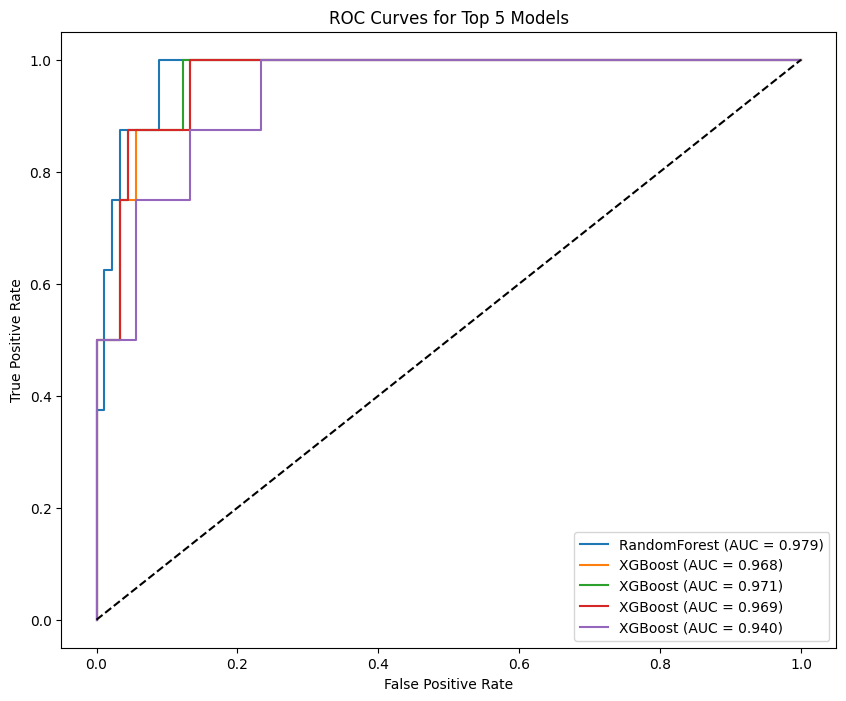


Optimal Thresholds and Performance:

Classifier: RandomForest
AUC Score: 0.9317
Optimal Threshold: 0.2297
Sensitivity: 0.8750
Specificity: 0.9667
Precision: 0.7000
Recall: 0.8750
F1 Score: 0.7778


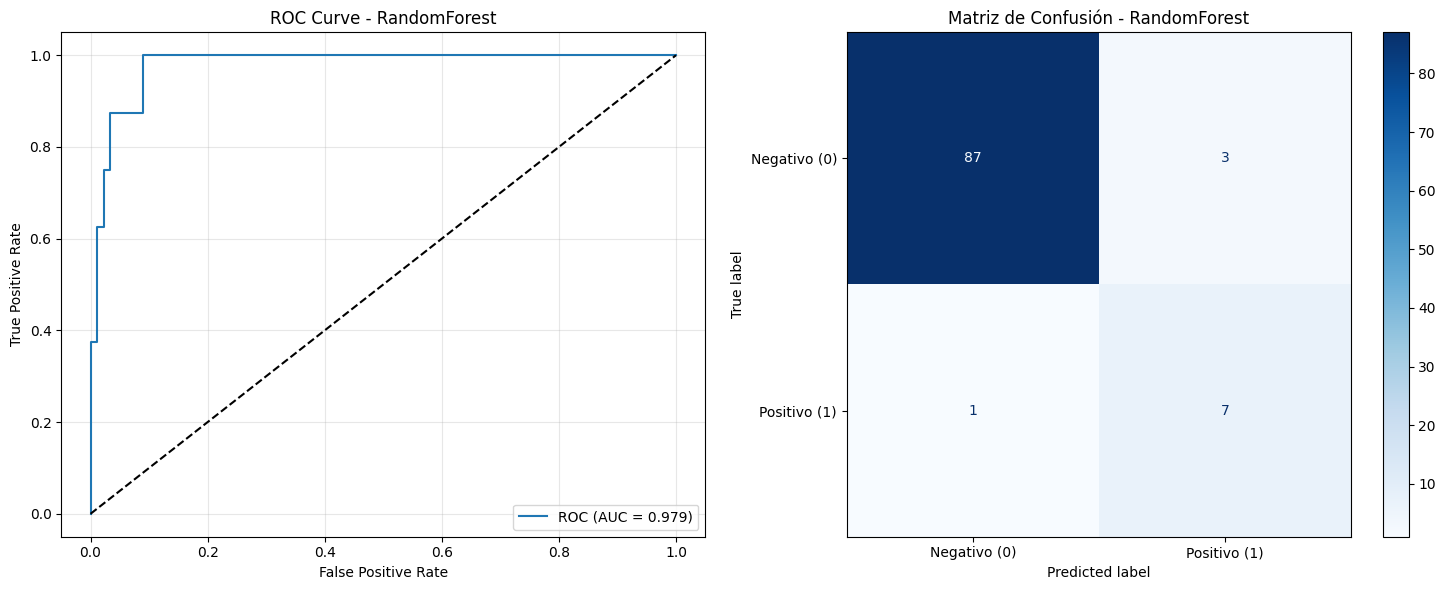


Classifier: XGBoost
AUC Score: 0.9281
Optimal Threshold: 0.1377
Sensitivity: 0.7500
Specificity: 0.9667
Precision: 0.6667
Recall: 0.7500
F1 Score: 0.7059


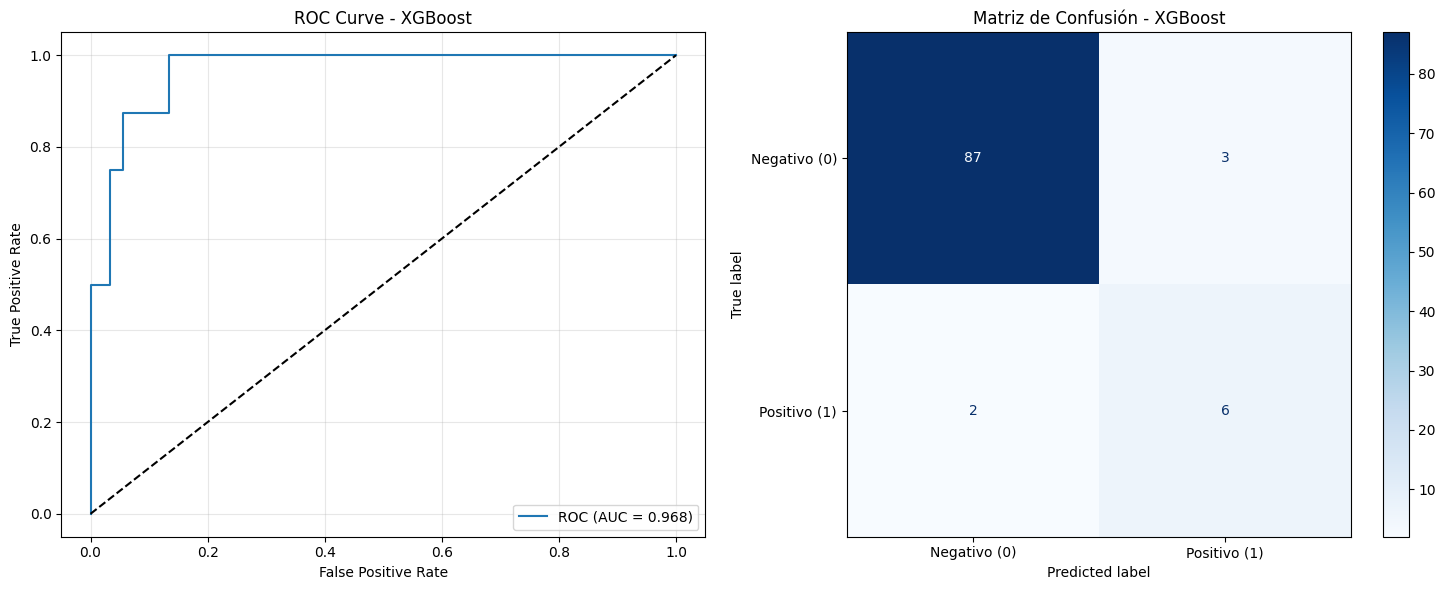


Classifier: XGBoost
AUC Score: 0.9278
Optimal Threshold: 0.1360
Sensitivity: 0.8750
Specificity: 0.9556
Precision: 0.6364
Recall: 0.8750
F1 Score: 0.7368


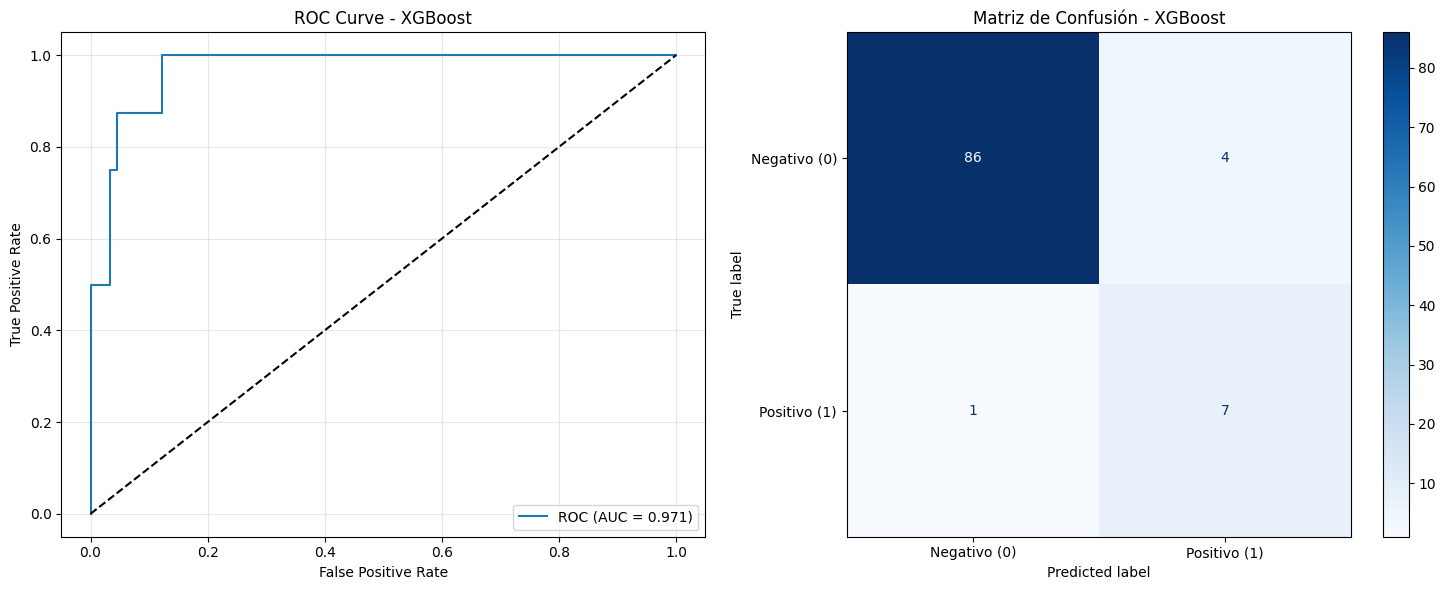


Classifier: XGBoost
AUC Score: 0.9273
Optimal Threshold: 0.1365
Sensitivity: 0.8750
Specificity: 0.9556
Precision: 0.6364
Recall: 0.8750
F1 Score: 0.7368


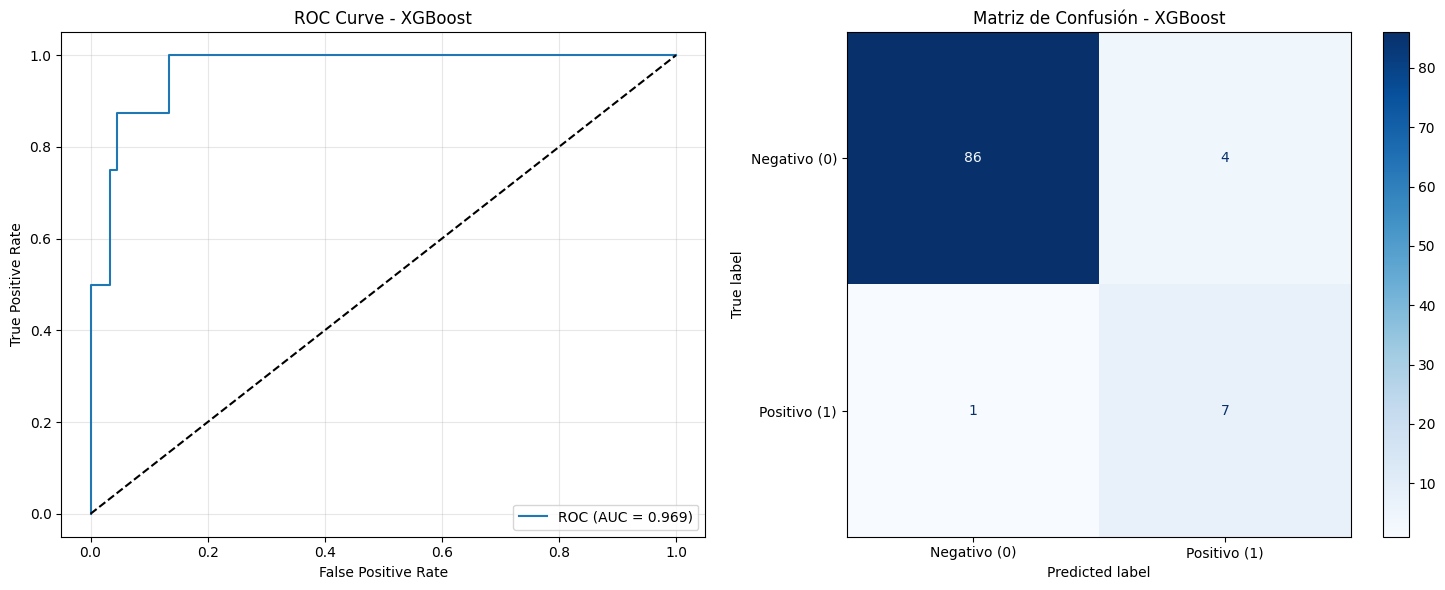


Classifier: XGBoost
AUC Score: 0.9266
Optimal Threshold: 0.2551
Sensitivity: 0.5000
Specificity: 1.0000
Precision: 1.0000
Recall: 0.5000
F1 Score: 0.6667


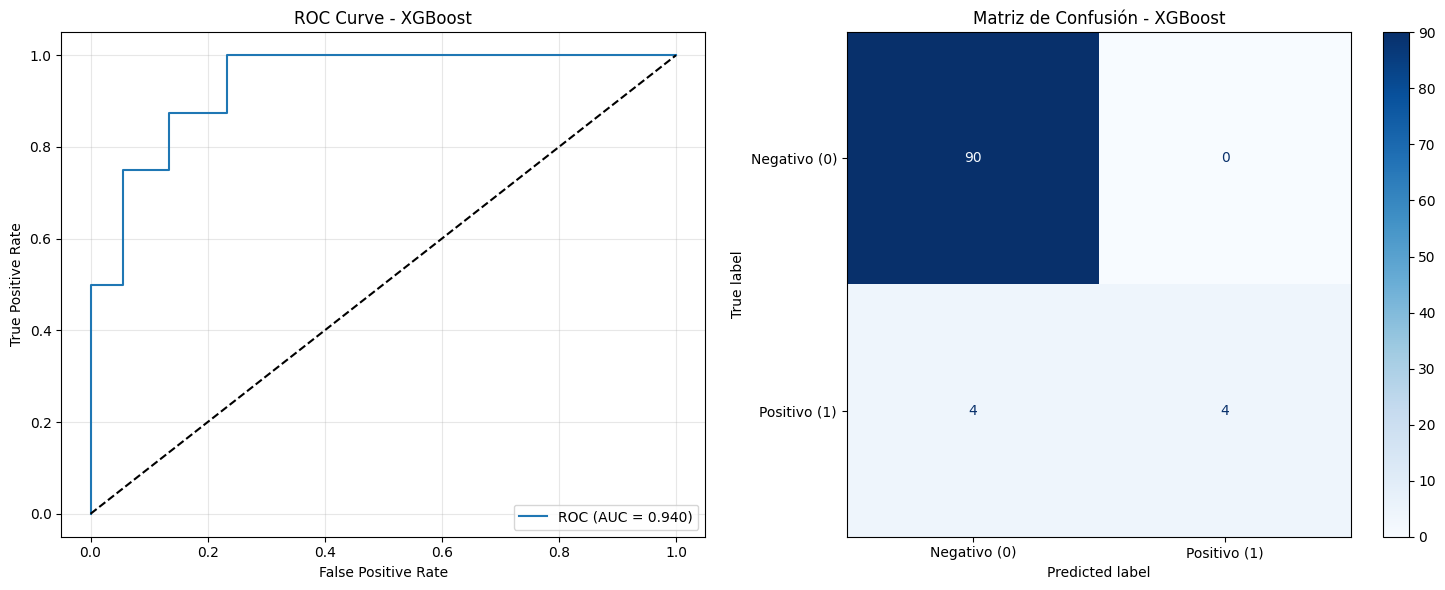

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Cargar los IDs de las ejecuciones de los 5 mejores modelos
run_ids_df = wr.s3.read_csv(f's3://models/{experiment_path}/top_5_run_ids.csv')

# Function to find optimal threshold
from sklearn.metrics import f1_score, roc_curve

def optimize_threshold(y_true, y_pred_proba):
    """
    Optimiza el umbral maximizando el F1-score.
    
    Args:
        y_true: valores reales de la clase.
        y_pred_proba: probabilidades predichas para la clase positiva.
    
    Returns:
        Umbral óptimo basado en F1-score.
    """
    # Obtener la curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)

    # Calcular el F1-score para cada umbral
    f1_scores = [f1_score(y_true, (y_pred_proba >= t).astype(int), average="binary") for t in thresholds]

    # Encontrar el umbral que maximiza el F1-score
    optimal_threshold = thresholds[np.argmax(f1_scores)]

    return optimal_threshold



# Evaluar cada modelo con optimización de umbral
results = []
for _, row in run_ids_df.iterrows():
    # Cargar modelo desde MLflow
    model = mlflow.sklearn.load_model(f"runs:/{row['run_id']}/model")
    
    # Obtener predicciones
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Encontrar el umbral óptimo
    optimal_threshold = optimize_threshold(y_test, y_pred_proba)
    
    # Calcular métricas con el umbral óptimo
    y_pred = (y_pred_proba >= optimal_threshold).astype(int)
    
    # Calcular sensibilidad y especificidad
    cm_total = confusion_matrix(y_test, y_pred)
    P = np.sum(cm_total[1, :])
    N = np.sum(cm_total[0, :])
    TP = cm_total[1, 1]
    TN = cm_total[0, 0]

    # Guardar resultados
    results.append({
        'classifier': row['classifier'],
        'auc_score': row['auc_score'],
        'optimal_threshold': optimal_threshold,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'sensitivity': TP/P,
        'specificity': TN/N,
        'confusion_matrix': cm_total,
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0, average='binary'),
    })

# Graficar curvas ROC para todos los modelos
plt.figure(figsize=(10, 8))
for result in results:
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = roc_auc_score(y_test, result['probabilities'])
    plt.plot(fpr, tpr, label=f"{result['classifier']} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Top 5 Models')
plt.legend()
plt.show()

# Print results
print("\nOptimal Thresholds and Performance:")
for result in results:
    print(f"\nClassifier: {result['classifier']}")
    print(f"AUC Score: {result['auc_score']:.4f}")
    print(f"Optimal Threshold: {result['optimal_threshold']:.4f}")
    print(f"Sensitivity: {result['sensitivity']:.4f}")
    print(f"Specificity: {result['specificity']:.4f}")
    print(f"Precision: {result['precision']:.4f}")
    print(f"Recall: {result['recall']:.4f}")
    print(f"F1 Score: {result['f1_score']:.4f}")

    # Create a figure with 1 row and 2 columns for ROC and Confusion Matrix
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = roc_auc_score(y_test, result['probabilities'])
    ax1.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--')  # diagonal line
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve - {result["classifier"]}')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Confusion Matrix
    # Plot Confusion Matrix con etiquetas personalizadas
    disp = ConfusionMatrixDisplay(confusion_matrix=result['confusion_matrix'],
                                display_labels=['Negativo (0)', 'Positivo (1)'])  # Etiquetas corregidas
    disp.plot(ax=ax2, values_format='d', cmap="Blues")  # Colores más intuitivos
    ax2.set_title(f'Matriz de Confusión - {result["classifier"]}')
    ax2.grid(False)

    
    plt.tight_layout()
    plt.show()